In [51]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from kerashypetune import KerasGridSearch

In [1]:
import numpy as np
import pandas as pd
from numpy import *
import math
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api
from statsmodels.tsa.stattools import coint
import seaborn as sns
import yfinance as yf

/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [ ]:
def filter_extreme_MAD(series,n): 
    median = series.quantile(0.5)
    new_median = ((series - median).abs()).quantile(0.50)
    max_range = median + n*new_median
    min_range = median - n*new_median
    return np.clip(series,min_range,max_range)

In [ ]:
def winsorize(factor, std=3, have_negative = True):
    r=factor.dropna().copy()
    if have_negative == False:
        r = r[r>=0]
    else:
        pass
    edge_up = r.mean()+std*r.std()
    edge_low = r.mean()-std*r.std()
    r[r>edge_up] = edge_up
    r[r<edge_low] = edge_low
    return r

In [ ]:
def standardize(s,ty=2):
    data=s.dropna().copy()
    if int(ty)==1:
        re = (data - data.min())/(data.max() - data.min())
    elif ty==2:
        re = (data - data.mean())/data.std()
    elif ty==3:
        re = data/10**np.ceil(np.log10(data.abs().max()))
    return re

In [47]:
prices_df =yf.download(['NVDA'], start = start_date,
                   end = end_date)
prices_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,131.042496,136.524994,129.625000,131.134995,130.998230,56064000
2021-01-05,130.997498,134.434998,130.869995,134.047501,133.907700,32276000
2021-01-06,132.225006,132.449997,125.860001,126.144997,126.013458,58042400
2021-01-07,129.675003,133.777496,128.865005,133.440002,133.300842,46148000
2021-01-08,133.625000,134.210007,130.419998,132.767502,132.629028,29252800
...,...,...,...,...,...,...
2022-02-22,230.350006,240.639999,230.000000,233.899994,233.860153,63342200
2022-02-23,238.020004,241.550003,223.009995,223.869995,223.831863,56651100
2022-02-24,210.149994,238.000000,208.899994,237.479996,237.439545,73580100


In [48]:
prices_df['avg_price'] = prices_df.apply (lambda row:(row['Open']+row['High']+row['Low']+row['Close'])/4, axis=1)
prices_df

,Open,High,Low,Close,Adj Close,Volume,avg_price
Date,,,,,,,
2021-01-04,131.042496,136.524994,129.625000,131.134995,130.998230,56064000,132.081871
2021-01-05,130.997498,134.434998,130.869995,134.047501,133.907700,32276000,132.587498
2021-01-06,132.225006,132.449997,125.860001,126.144997,126.013458,58042400,129.170000
2021-01-07,129.675003,133.777496,128.865005,133.440002,133.300842,46148000,131.439377
2021-01-08,133.625000,134.210007,130.419998,132.767502,132.629028,29252800,132.755627
...,...,...,...,...,...,...,...
2022-02-22,230.350006,240.639999,230.000000,233.899994,233.860153,63342200,233.722500
2022-02-23,238.020004,241.550003,223.009995,223.869995,223.831863,56651100,231.612499
2022-02-24,210.149994,238.000000,208.899994,237.479996,237.439545,73580100,223.632496


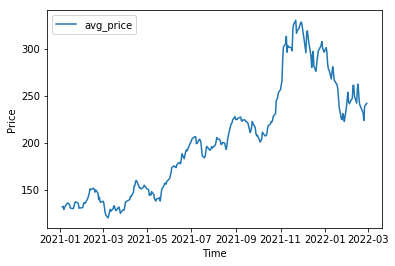

In [50]:
plt.plot(prices_df['avg_price'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [52]:
### DEFINE T2V LAYER ###
class T2V(tf.keras.layers.Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                      shape=(input_shape[-1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.P = self.add_weight(name='P',
                      shape=(input_shape[1], self.output_dim),
                      initializer='uniform',
                      trainable=True)
        self.w = self.add_weight(name='w',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        self.p = self.add_weight(name='p',
                      shape=(input_shape[1], 1),
                      initializer='uniform',
                      trainable=True)
        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p  #Fitting non-periodic patterns
        sin_trans = K.sin(K.dot(x, self.W) + self.P)  #Fitting periodic patterns
        
        return K.concatenate([sin_trans, original], -1)

In [85]:
### CREATE GENERATOR FOR LSTM AND T2V ###

sequence_length = 20

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [86]:
### DEFINE MODEL STRUCTURES ###
def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def T2V_NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m


def NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(param['unit'], activation=param['act'])(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

In [87]:
prices_df = prices_df.dropna()
prices_df['avg_price']

Date
2021-01-04    132.081871
2021-01-05    132.587498
2021-01-06    129.170000
2021-01-07    131.439377
2021-01-08    132.755627
                 ...    
2022-02-22    233.722500
2022-02-23    231.612499
2022-02-24    223.632496
2022-02-25    238.690002
2022-02-28    241.872501
Name: avg_price, Length: 291, dtype: float64

In [88]:
### PREPARE DATA TO FEED MODELS ###
X, Y = [], []
for sequence in gen_sequence(prices_df, sequence_length, ['avg_price']):
    X.append(sequence)
    
for sequence in gen_labels(prices_df, sequence_length, ['avg_price']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

In [89]:
X

array([[[132.08187103],
        [132.58749771],
        [129.17000008],
        ...,
        [130.86874771],
        [130.77750397],
        [131.15937424]],

       [[132.58749771],
        [129.17000008],
        [131.43937683],
        ...,
        [130.77750397],
        [131.15937424],
        [134.53250122]],

       [[129.17000008],
        [131.43937683],
        [132.75562668],
        ...,
        [131.15937424],
        [134.53250122],
        [136.53687286]],

       ...,

       [[230.92250061],
        [227.95499802],
        [222.51499939],
        ...,
        [240.98999786],
        [233.72249985],
        [231.61249924]],

       [[227.95499802],
        [222.51499939],
        [238.07250214],
        ...,
        [233.72249985],
        [231.61249924],
        [223.63249588]],

       [[222.51499939],
        [238.07250214],
        [246.94249725],
        ...,
        [231.61249924],
        [223.63249588],
        [238.69000244]]])

In [90]:
train_dim = int(0.7*len(prices_df))
X_train, X_test = X[:train_dim], X[train_dim:]
y_train, y_test = Y[:train_dim], Y[train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(203, 20, 1) (203, 1)
(68, 20, 1) (68, 1)


In [92]:
from keras.callbacks import EarlyStopping
param_grid = {
    'unit': [64,32],
    't2v_dim': [128,64],
    'lr': [1e-2,1e-3], 
    'act': ['elu','relu'], 
    'epochs': 200,
    'batch_size': [512,1024]
}

### FIT T2V + LSTM ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: T2V_NN(param=x, dim=sequence_length)

kgs_t2v = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
#kgs_t2v.set_seed(set_seed_TF2, seed=33)
kgs_t2v.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)


32 trials detected for ('unit', 't2v_dim', 'lr', 'act', 'epochs', 'batch_size')

***** (1/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 512})


/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


SCORE: 22043.74219 at epoch 9

***** (2/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 5309.30762 at epoch 9

***** (3/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 1837.56274 at epoch 8

***** (4/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 10549.63379 at epoch 2

***** (5/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.001, 'act': 'relu', 'epochs': 200, 'batch_size': 512})
SCORE: 8978.90527 at epoch 19

***** (6/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.001, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 14850.04004 at epoch 10

***** (7/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.001, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 6972.05566 at epoch 21

***** (8/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.001, 'act': 'elu

In [93]:
pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_t2v)

21.010975445018094

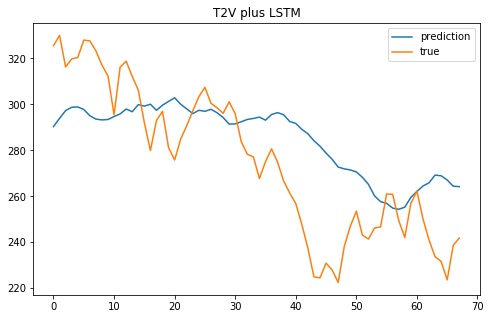

In [94]:
plt.figure(figsize=(8,5))

plt.plot(pred_t2v[:365], label='prediction')
plt.plot(y_test.ravel()[:365], label='true')
plt.title('T2V plus LSTM'); plt.legend()

In [95]:
### FIT SIMPLE LSTM ###

del param_grid['t2v_dim']

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: NN(param=x, dim=sequence_length)

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
#kgs.set_seed(set_seed_TF2, seed=33)
kgs.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)



16 trials detected for ('unit', 'lr', 'act', 'epochs', 'batch_size')

***** (1/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 512})


/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


SCORE: 1599.76733 at epoch 7

***** (2/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 15536.31055 at epoch 1

***** (3/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 8873.02148 at epoch 10

***** (4/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 2591.08691 at epoch 11

***** (5/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'relu', 'epochs': 200, 'batch_size': 512})
SCORE: 20706.24609 at epoch 1

***** (6/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 252.42068 at epoch 39

***** (7/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 79580.50781 at epoch 2

***** (8/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 79800.89844 at epoch 8

***** (9/16) *****
Search({'unit': 32, 'lr'

In [96]:
pred_nn = kgs.best_model.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_nn)

26.9251470004811